In [1]:
import json, argparse, os
from turtle import width
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.widgets import Slider, TextBox
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.animation as animation
from matplotlib import markers, rcParams
import numpy as np
import seaborn as sns
plt.style.use("./tplot.mplstyle")

In [2]:
N=30
ab=10.0
t2=20.0
t3=50.0
a=10.0
b=1.0
omega0s=np.array([0.04,0.05, 0.06, 0.07, 0.08])
inits = np.arange(100,2500, 100)
dt=0.1
tf=10050.1

In [3]:
Sols=np.zeros((len(omega0s), len(inits), int(tf/dt), N+1))
for o in np.arange(len(omega0s)):
    for i in np.arange(len(inits)):
        Sols[o,i] += ((np.fromfile("osc_strain_phase_0.5_disp/{:d}/{:1.1f}/{:1.1f}/{:1.1f}/{:1.2f}/solution_{:1.2f}.dat".format(N, ab, t2, t3, omega0s[o], inits[i]))).reshape(int(tf/dt), 3*N+1))[:,:N+1]
Sols-=np.arange(0,N+1,1)[np.newaxis,np.newaxis,np.newaxis,:]
#for some reason i=0 is weird so ignore it

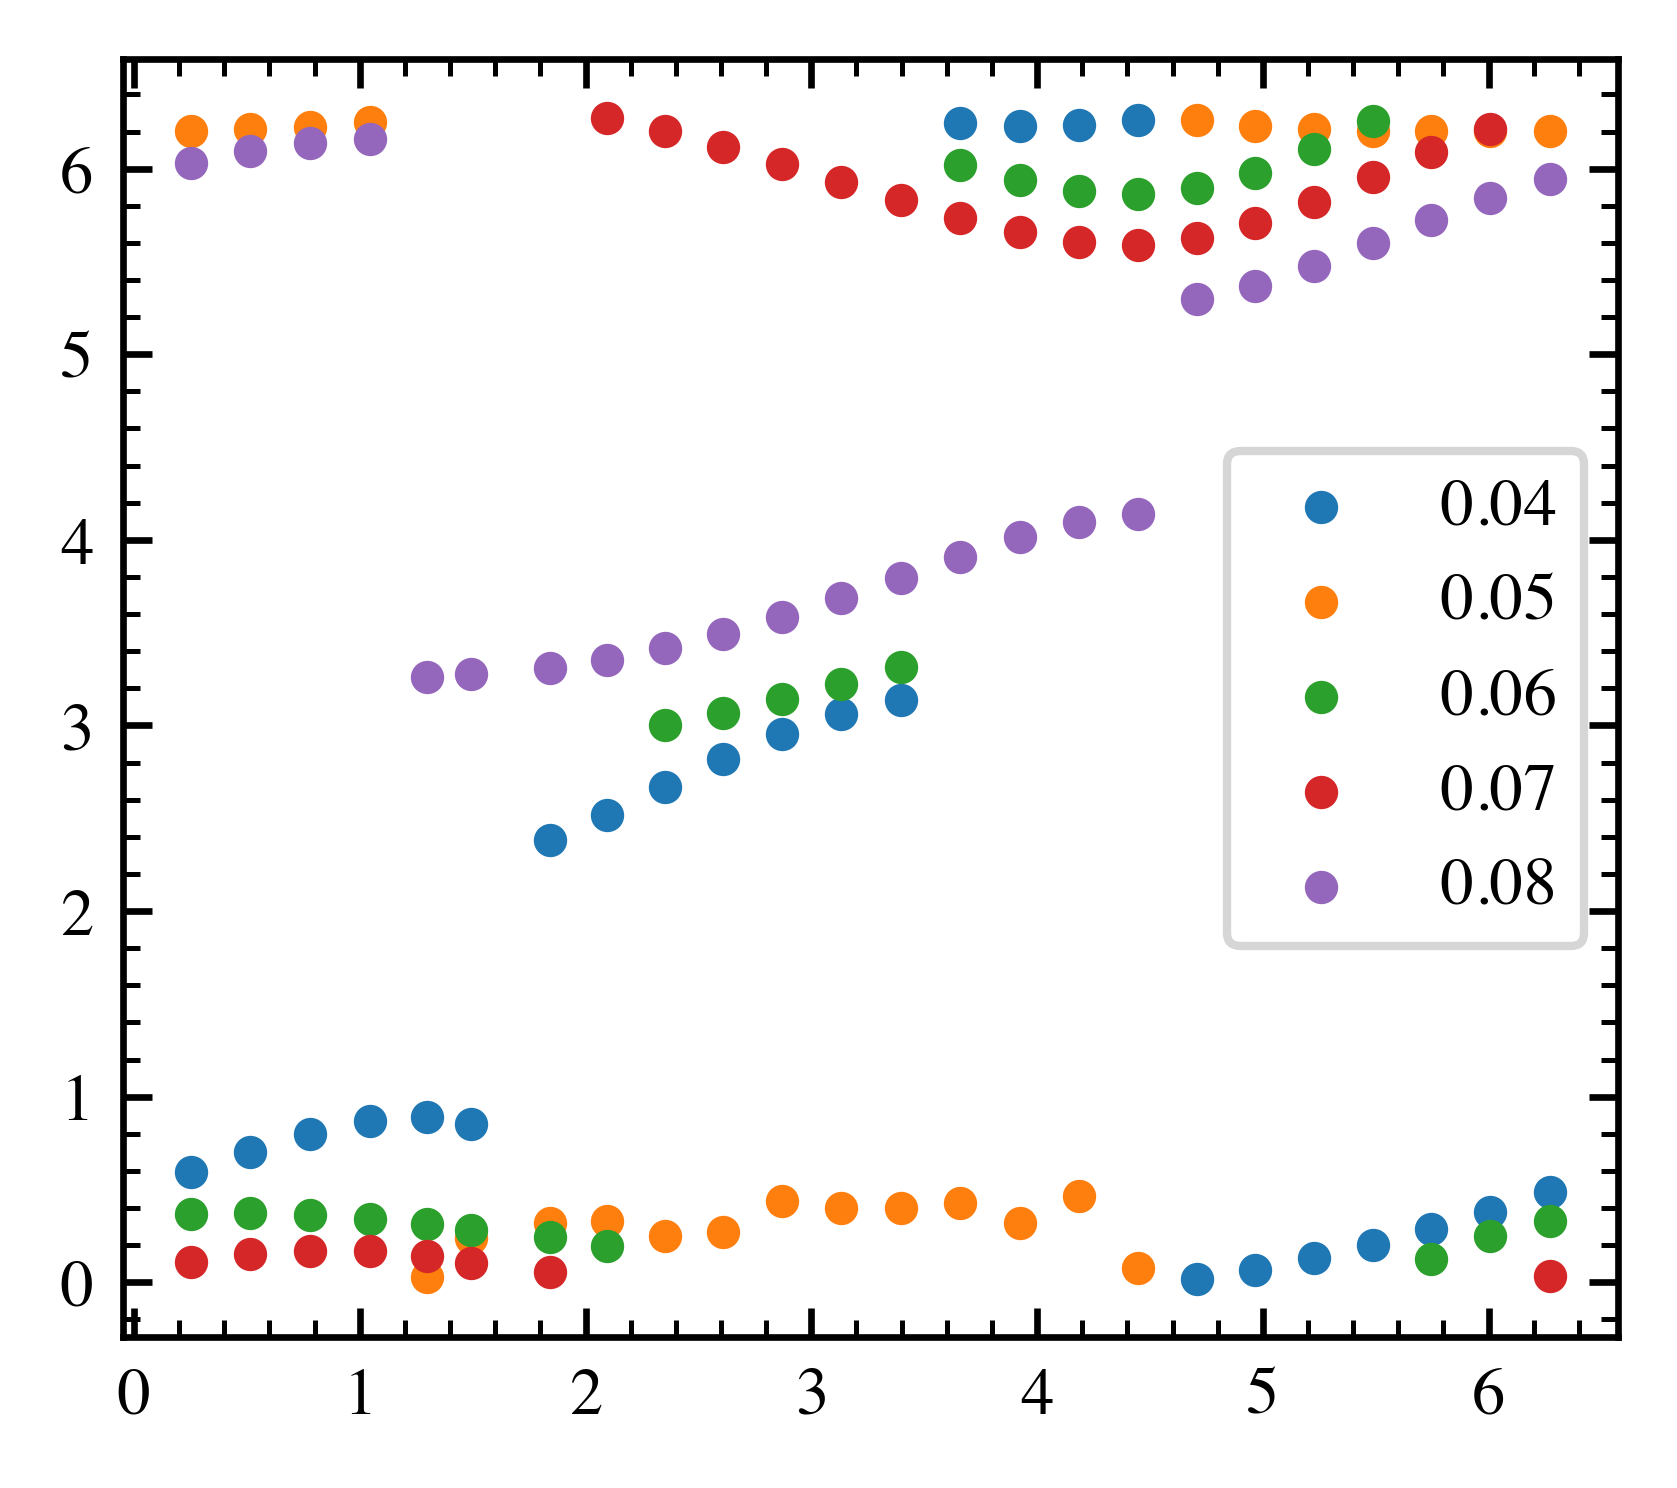

In [4]:
n=1 #which cell?
A = np.max(np.abs(Sols[:,:,:500,n]))
Delta = Sols[:,:,500,n]-Sols[:,:,499,n]
theta = np.arcsin(Sols[:,:,500,n]/A)
theta=np.where(np.sign(Delta) == np.sign(theta), theta, np.sign(theta)*(np.pi-np.abs(theta)))   #this is in -pi/2, pi/2
phase=np.where(theta<0, np.pi-theta, theta) #this is in 0 to pi
#relphase = -phase   #since the pull is leftward, pull function is actually -sin(wt)=sin(-wt), so phase relative to the pull is -ve

#find_final phase
A = np.max(np.abs(Sols[:,:,-5000:,n]))
Delta = Sols[:,:,-1,n]-Sols[:,:,-2,n]
theta = np.arcsin(Sols[:,:,-1,n]/A)
theta=np.where(np.sign(Delta) == np.sign(theta), theta, np.sign(theta)*(np.pi-np.abs(theta)))   #this is in -pi/2, pi/2
finphase=np.where(theta<0, np.pi-theta, theta) #this is in 0 to pi
#relphase = -phase   #since the pull is leftward, pull function is actually -sin(wt)=sin(-wt), so phase relative to the pull is -ve
for i in np.arange(len(omega0s)):
    plt.scatter(phase[i], finphase[i],label=omega0s[i])
plt.legend()
plt.show()

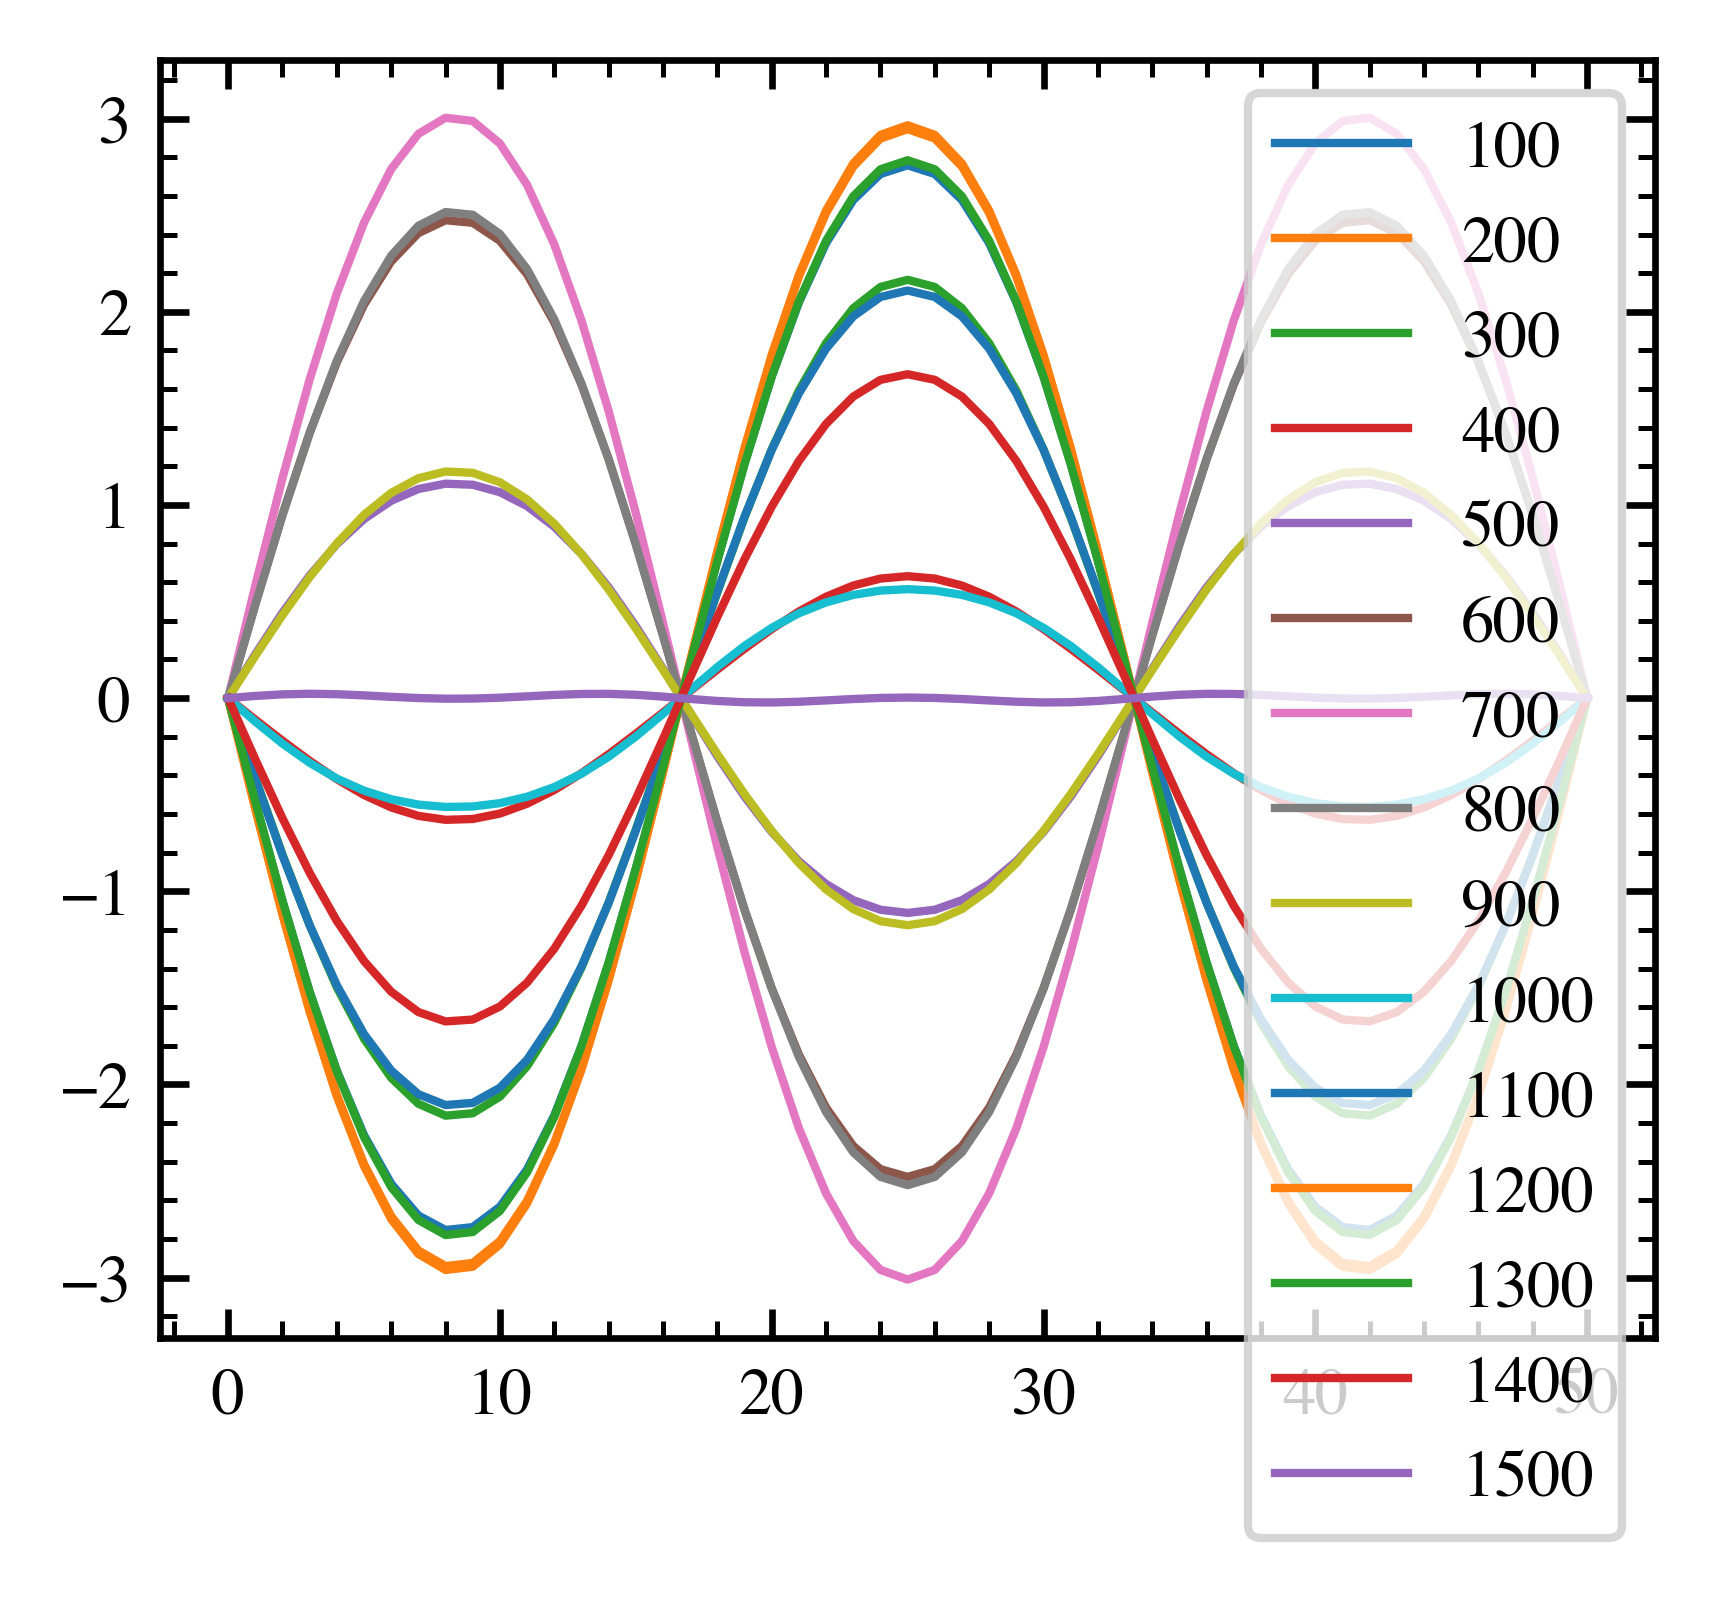

In [251]:
plt.plot(np.arange(0,N+1,1), Sols[0,:,500].T, label=inits)
plt.legend()
plt.show()

In [5]:
Disps=Sols[:,:,50000:,:]
fftufields = np.fft.rfft(Disps,axis=2)
mags = np.abs(fftufields)
freqs = np.fft.rfftfreq(len(Disps[0,0,:,0]), dt)
fftBufields = np.zeros_like(fftufields)
fftAufields = np.zeros_like(fftufields)
thetas = np.zeros((len(omega0s), len(inits), N+1))
for i in np.arange(len(omega0s)):
    index=np.where(freqs*2*np.pi//omega0s[i]==1)[0][0]
    fftBufields[i,:,index,:]+=fftufields[i,:,index,:]
    thetas[i] = np.angle(fftufields[i,:,index,:])
    index=np.argmax(mags[i,0,:,10])
    #index=47 #for N=50
    #index=42 #for N=20
    #print(np.abs(fftufields[i,:,40:44,10]))
    #thetas[i] += np.angle(fftufields[i,:,index,:])
    fftAufields[i,:,index,:]+=fftufields[i,:,index,:]
Bufields = np.fft.irfft(fftBufields,axis=2)
Aufields = np.fft.irfft(fftAufields,axis=2)


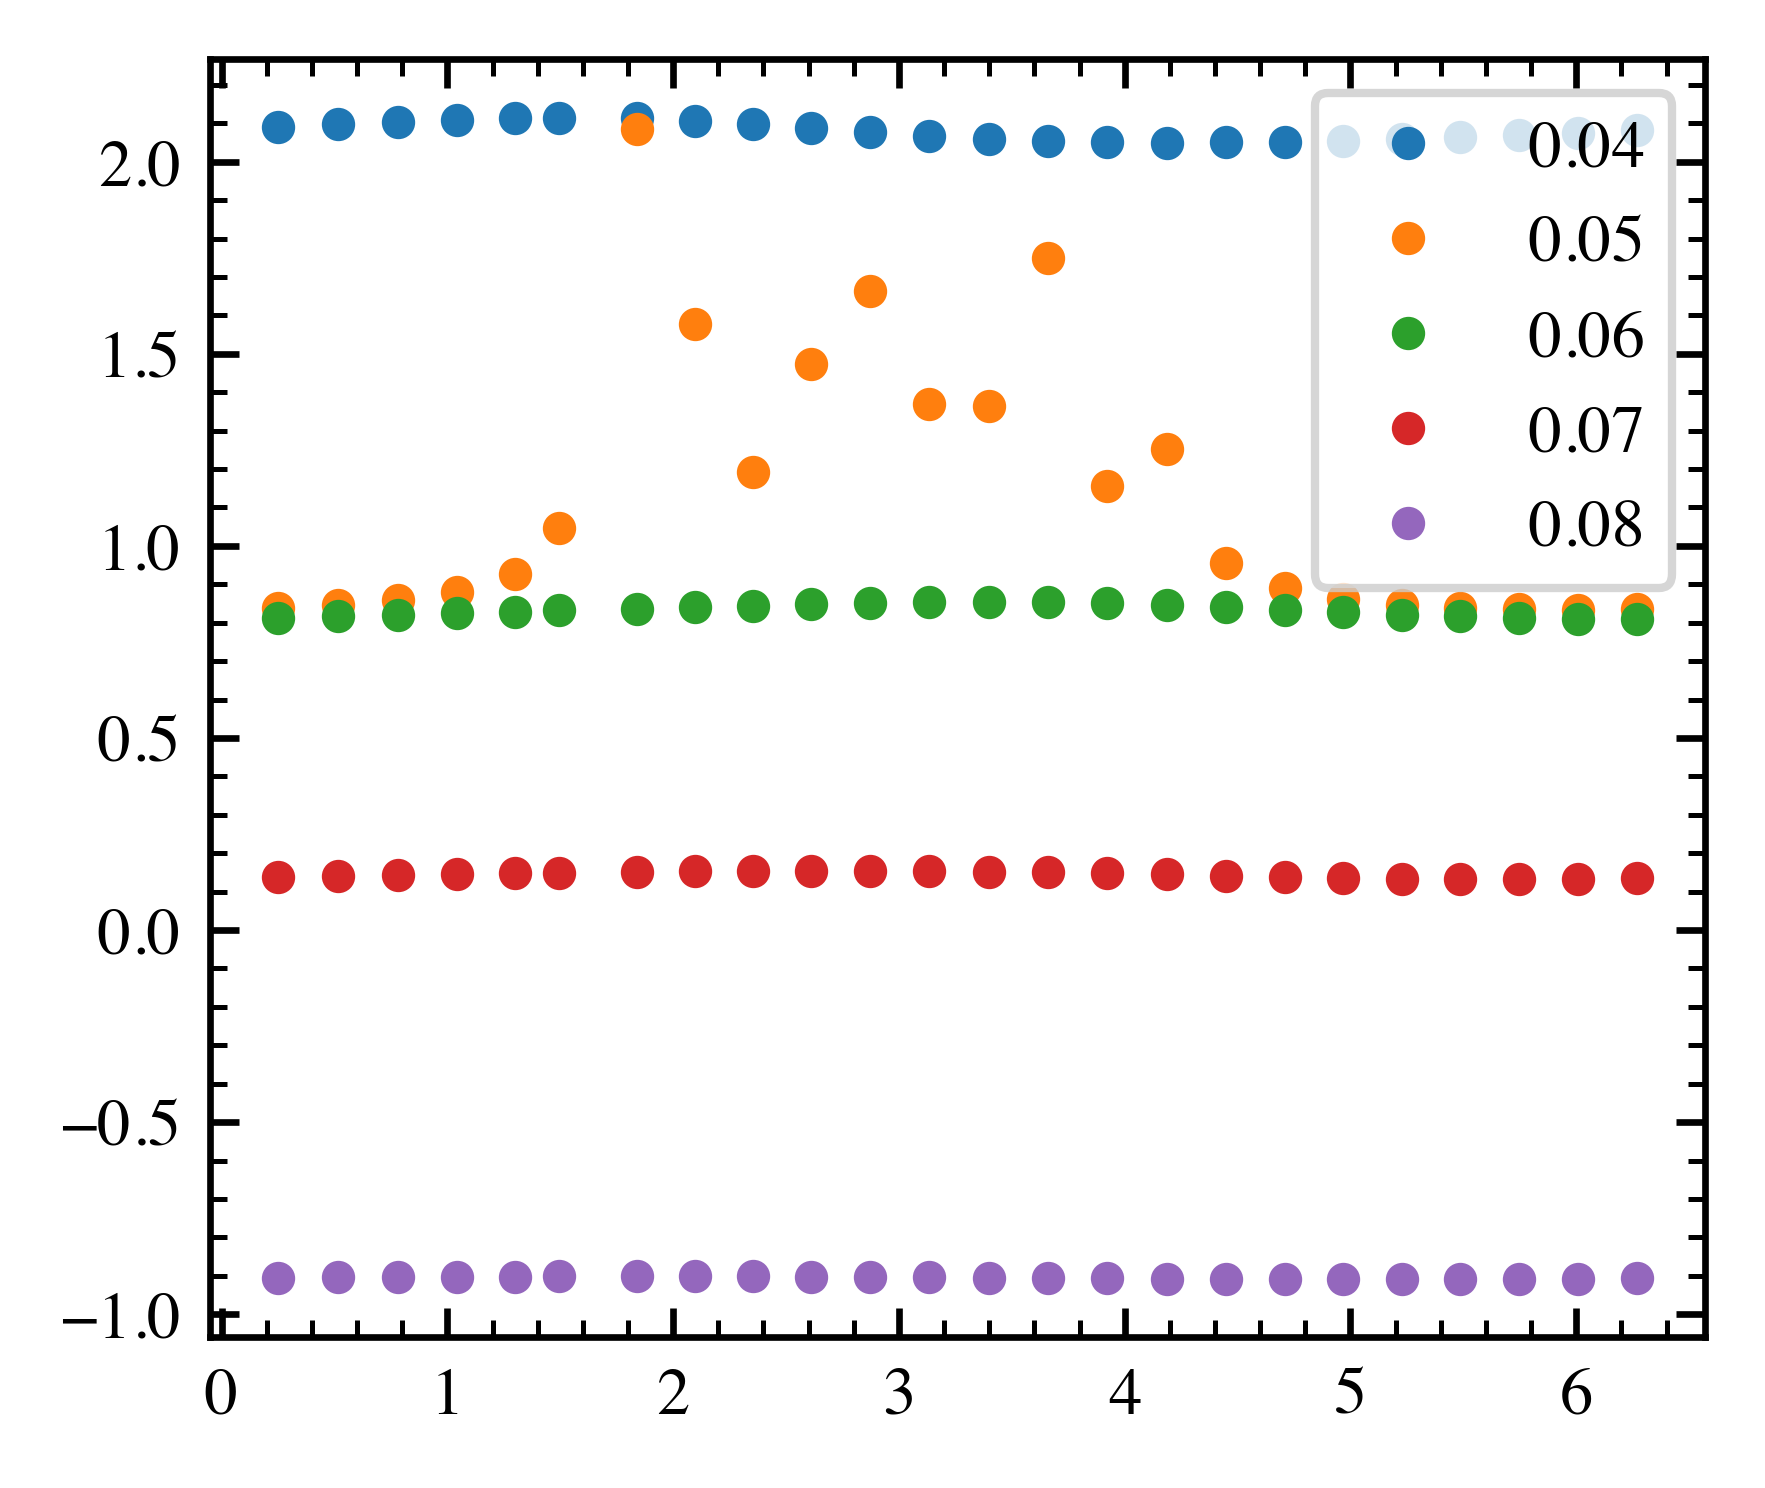

In [6]:
o=2
plt.plot(phase[o], thetas[:,:,1].T,marker='o',linestyle='',label=omega0s)
plt.legend()
plt.show()

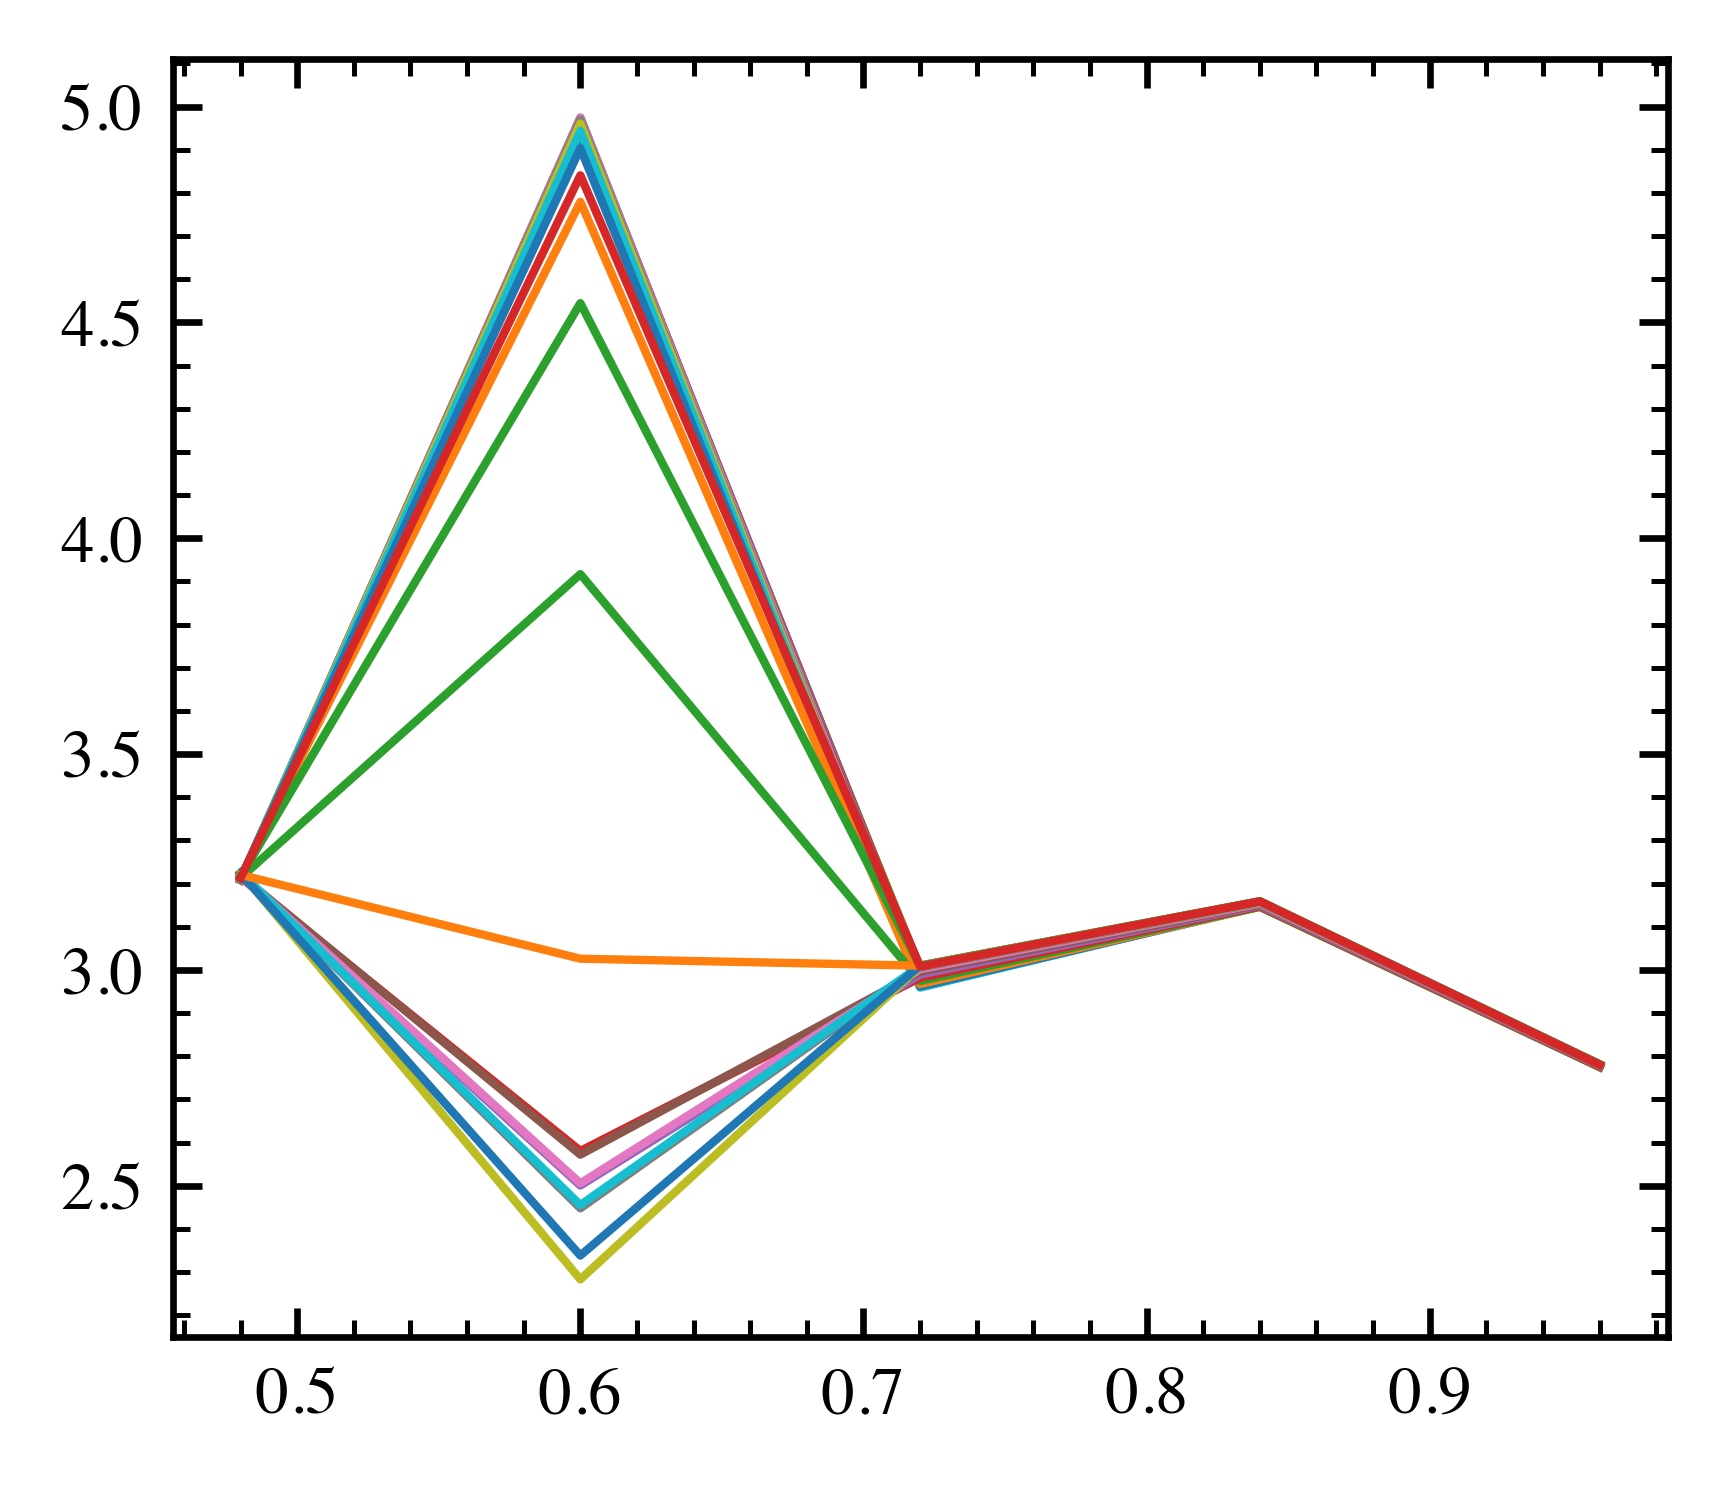

In [7]:
maxdisp=np.max(Aufields, axis=2)
n=10
plt.plot(omega0s*12, maxdisp[:,:,n])
#plt.plot(phase[0], maxdisp[:,:,n].T,marker='o',linestyle='')
plt.show()

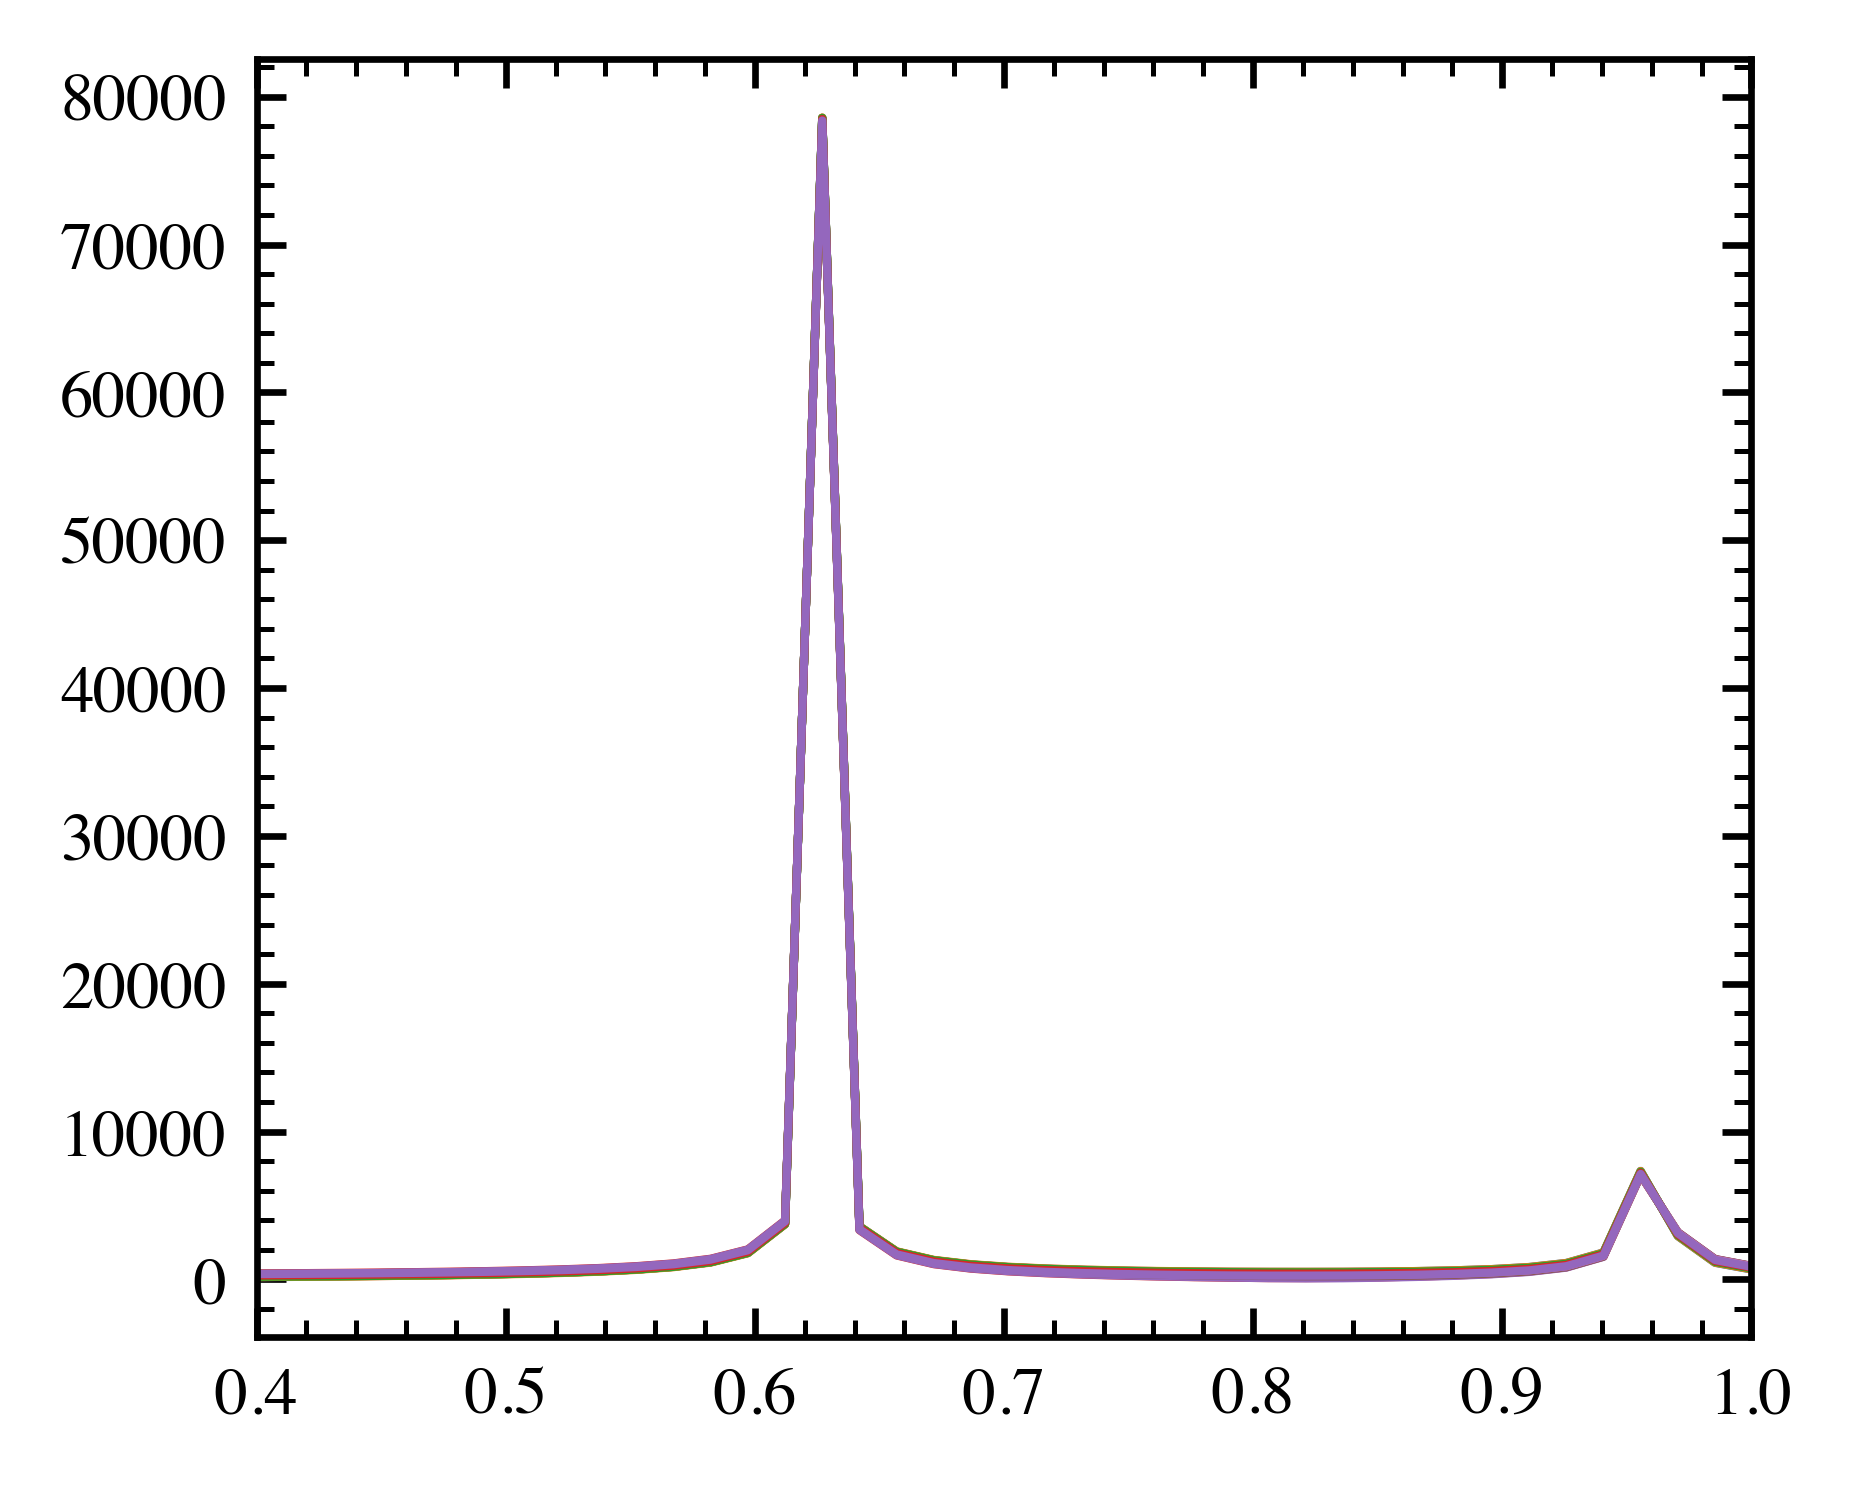

In [241]:
n=10
plt.plot(freqs*24*np.pi, np.abs(fftufields[4,:,:,n]).T)
plt.xlim(0.4,1)
plt.show()

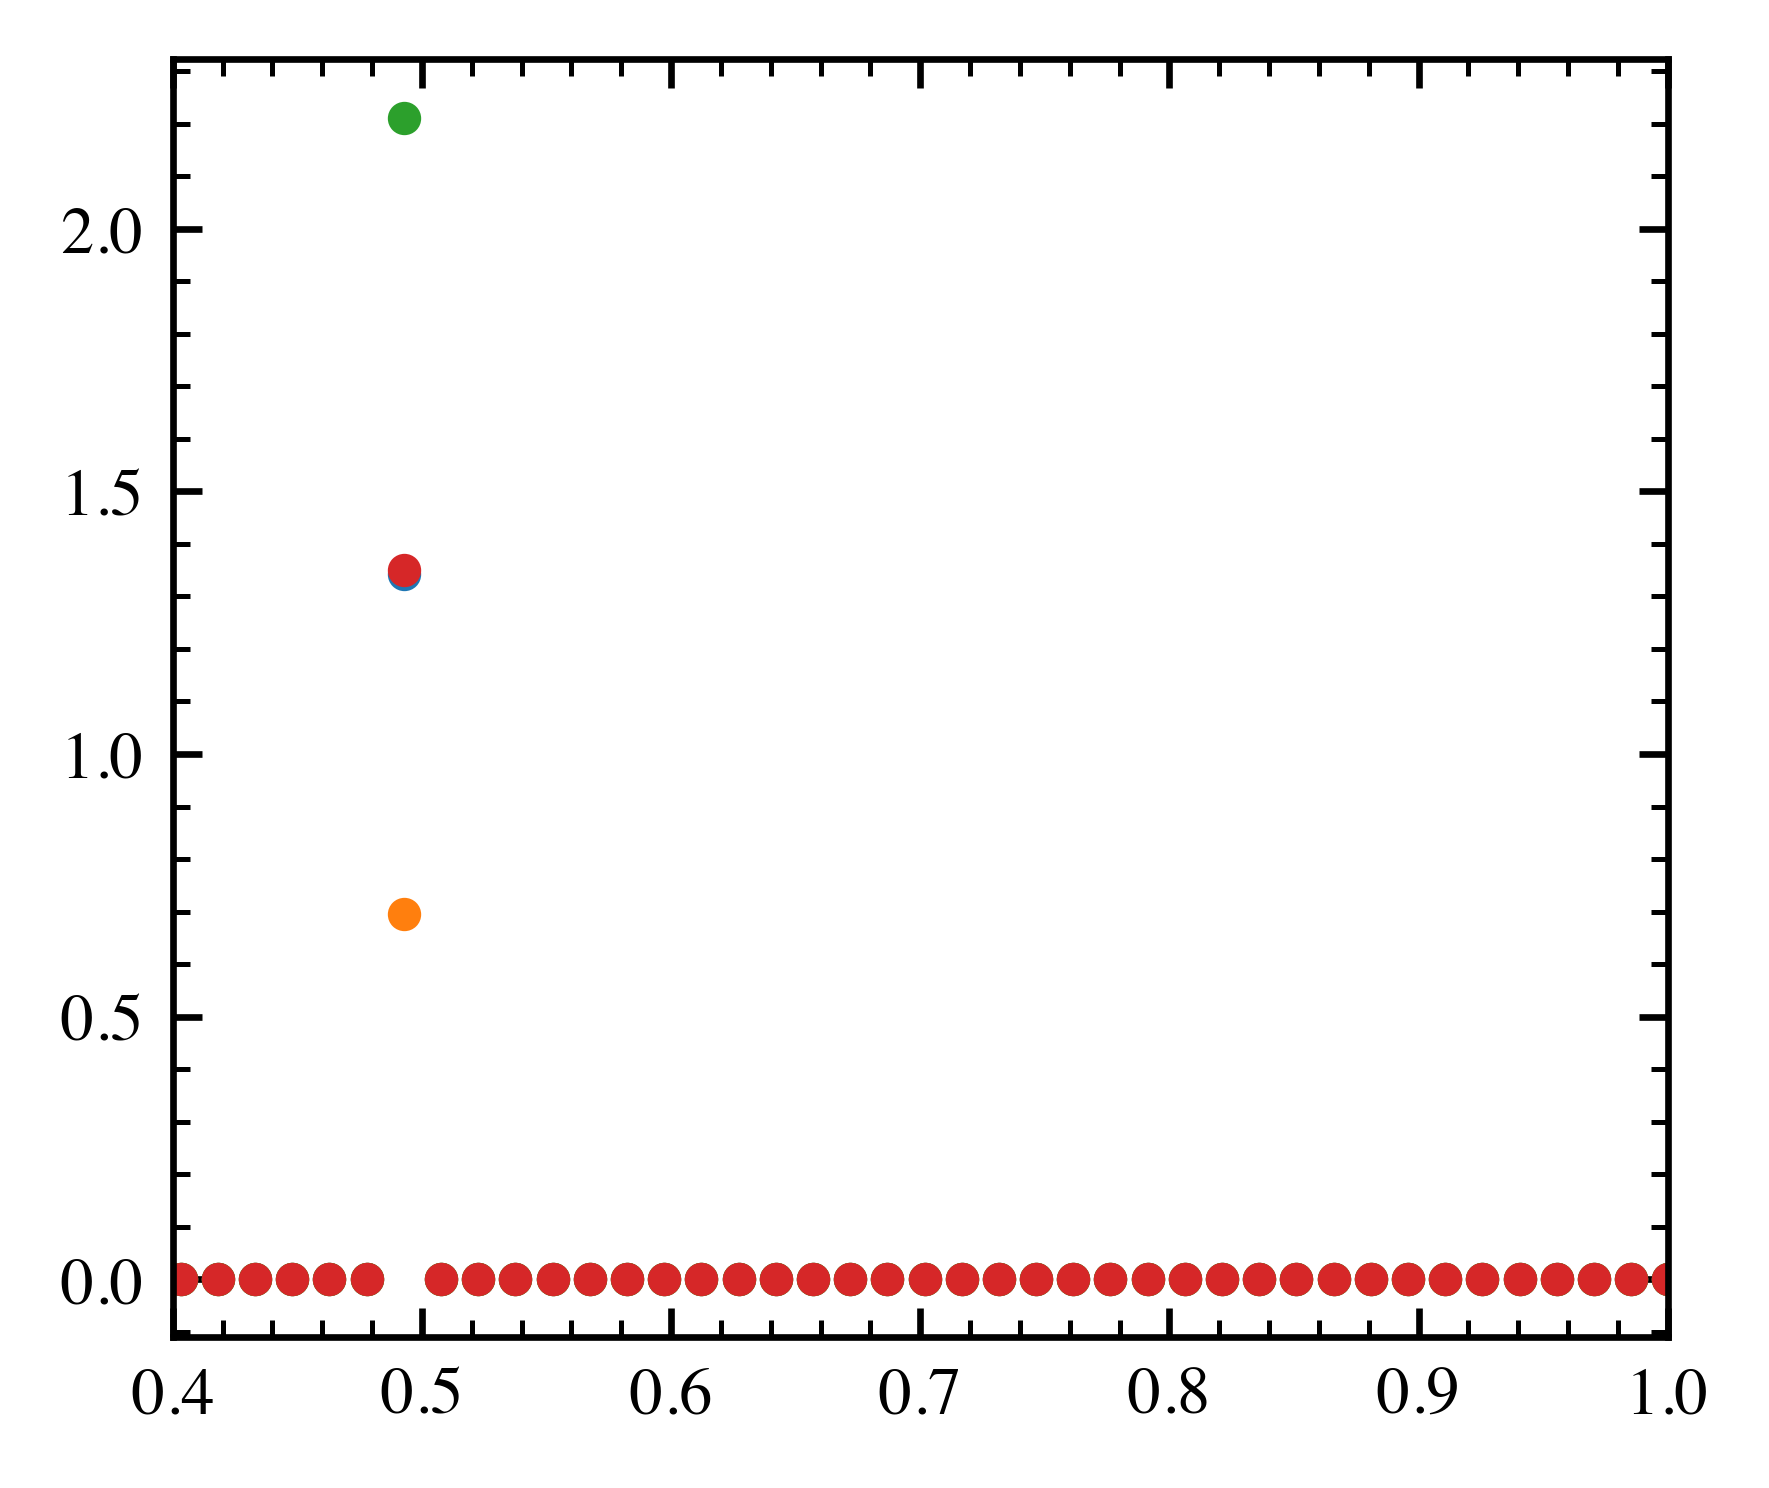

In [231]:
n=10
plt.plot(freqs*24*np.pi, np.angle(fftBufields[0,1:-1:4,:,n]).T, linestyle='',marker='o')
plt.xlim(0.4,1)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


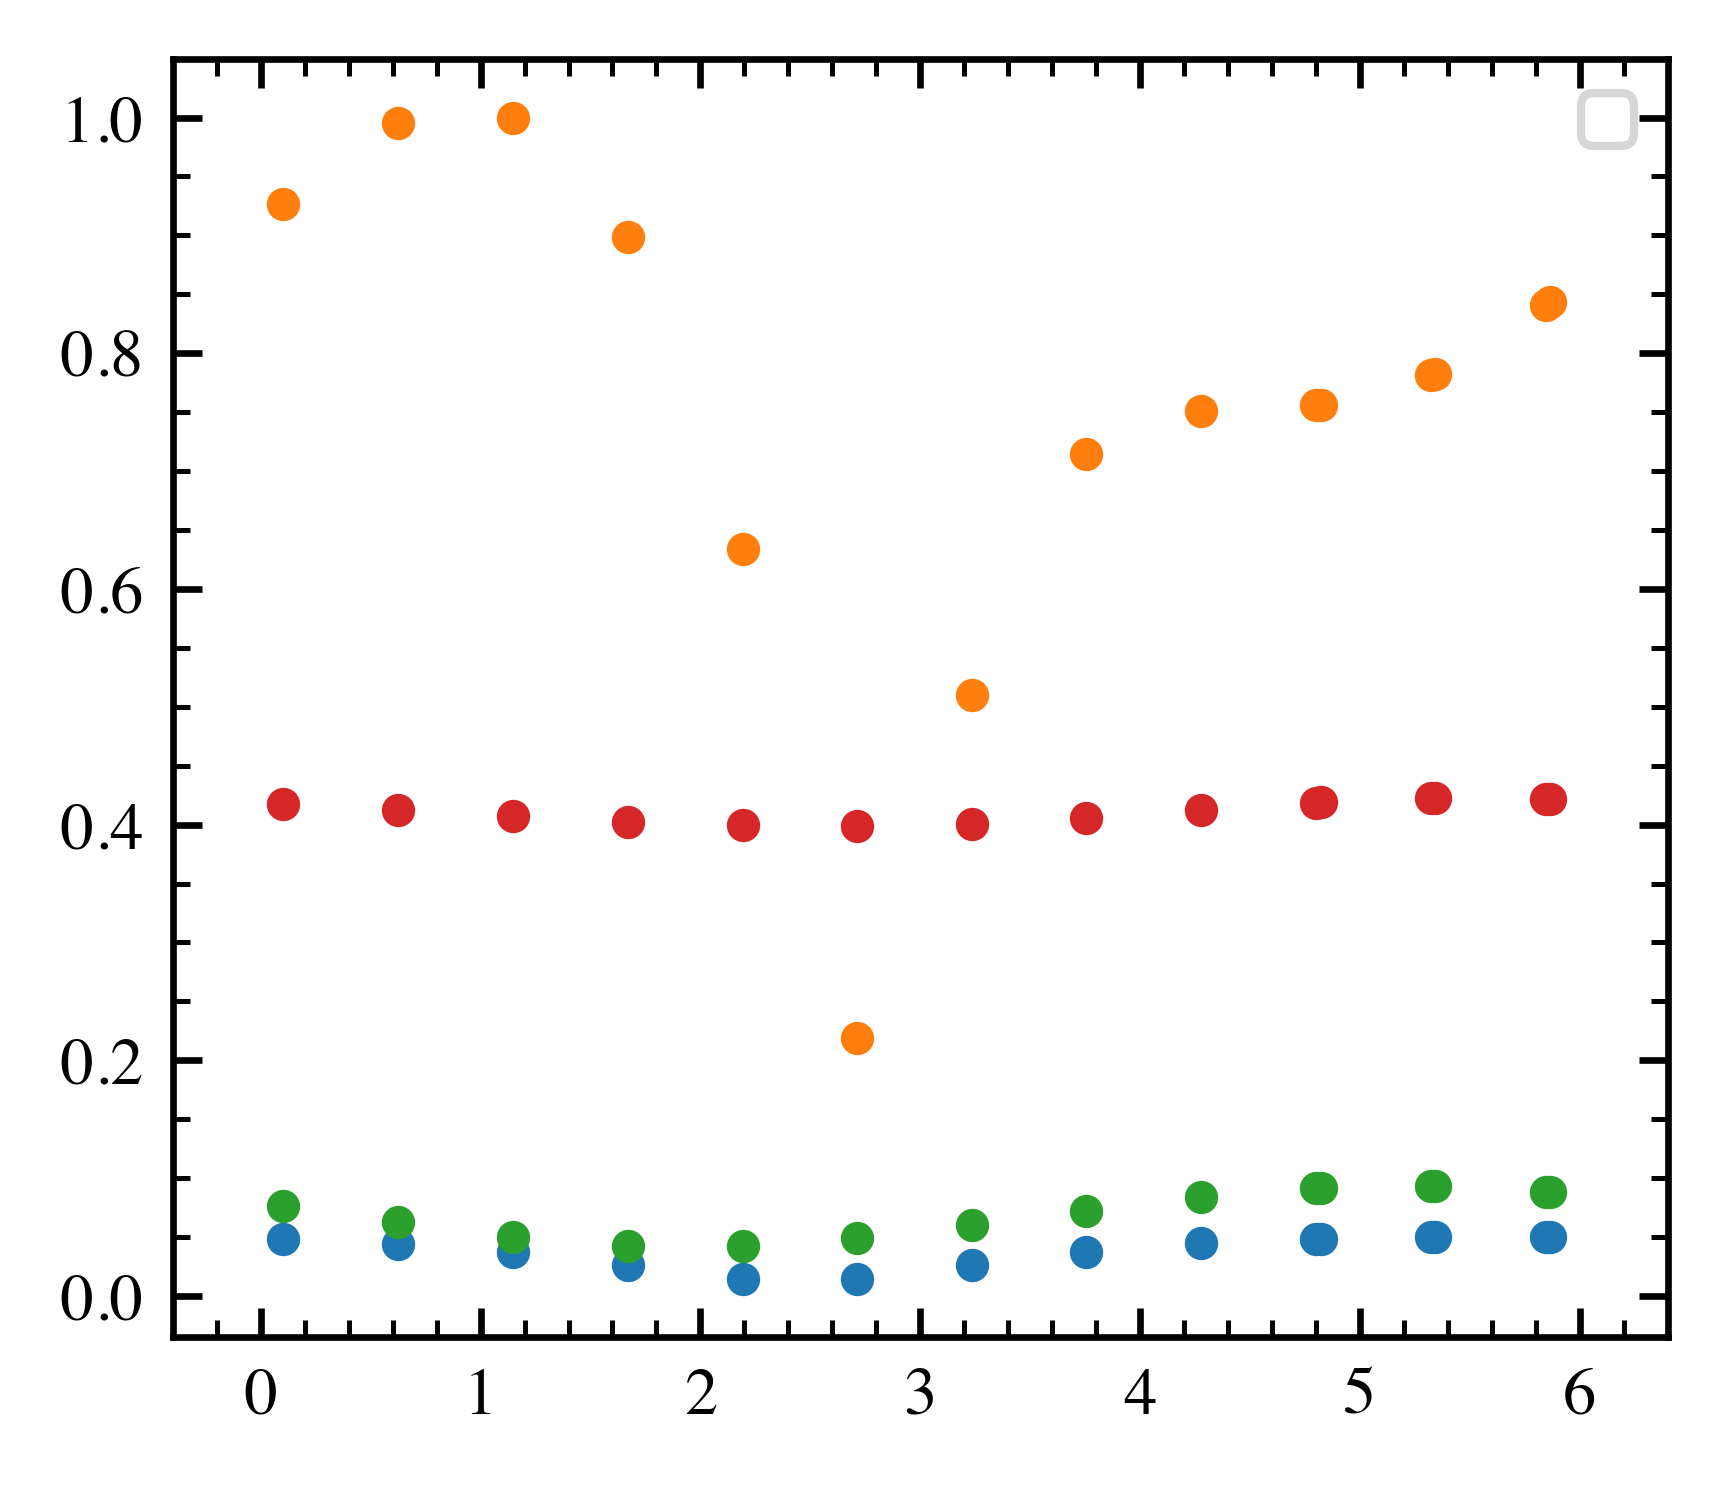

[0.62706192 0.62706192 0.62706192 0.62706192 0.62706192 0.62706192
 0.62706192 0.62706192 0.62706192 0.62706192 0.62706192 0.62706192
 0.62706192 0.62706192 0.62706192]
[67305.89045242 67664.21603421 67797.20778517 67816.75228357
 67986.55580068 68707.07203202 69368.74345149 69216.76342706
 67500.60855857 65684.20967817 65796.09450651 66627.59046575
 67286.88395211 67655.2865033  67795.19547314]


In [232]:
n=10
for o in [0,1,2,3]:
    #plt.scatter(relphase[o], np.max(np.abs(fftufields[o,:,:,n]), axis=1)/np.max(np.abs(fftufields[:,:,:,n])))#,c='b')
    #plt.scatter(phase[o], np.max(np.abs(fftBufields[o,:,:,n]), axis=1)/np.max(np.abs(fftBufields[:,:,:,n])))#,c='y')
    #plt.plot(relphase[o], np.max(np.abs(fftufields[o,:,:,0:-1:5]), axis=1), linestyle='', marker='o',label=np.arange(0,N,5))#,c='g')
    #plt.scatter(relphase[o], np.max(np.abs(fftufields[o,:,:,n]), axis=1)+np.max(np.abs(fftBufields[o,:,:,n]), axis=1),c='g')
    #plt.plot(freqs*24*np.pi, np.abs(fftBufields[o,:,:,-10].T))
plt.xlim(-0.4,6.4)
plt.legend()
plt.show()
print(24*np.pi*freqs[np.argmax(abs(fftufields[1,:,:,n]), axis=1)])
print(np.max(abs(fftufields[1,:,:,n]), axis=1))

In [ ]:
fftAufields = np.zeros_like(fftufields)


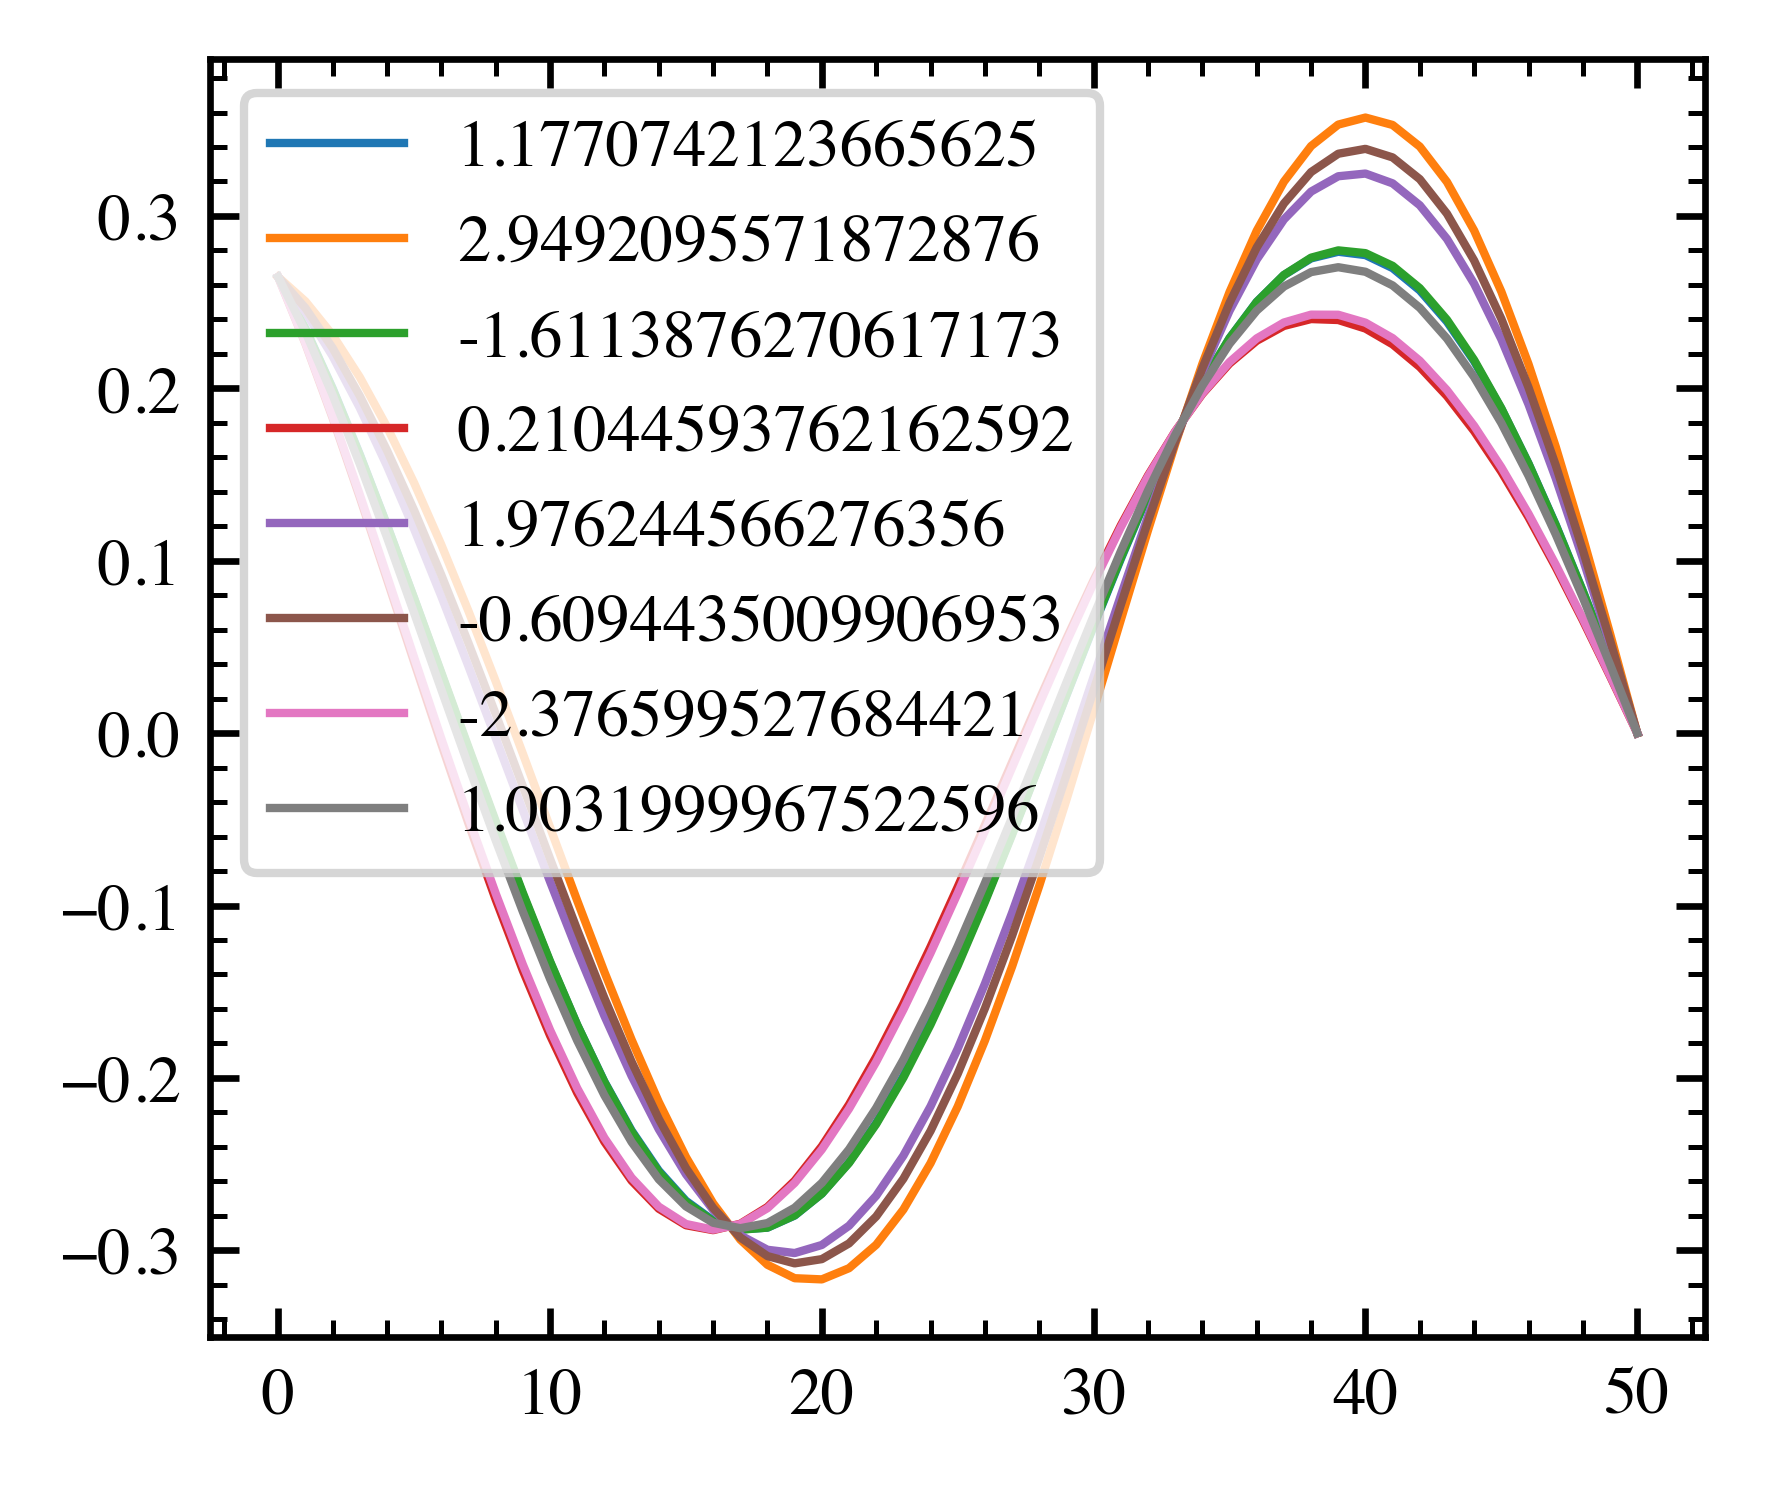

In [256]:
plt.plot(np.arange(0,N+1,1), Bufields[0,0:-1:3,-1].T, label=relphase[0,0:-1:3])
plt.legend()
plt.show()